In [1]:
%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim import Adam
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import numpy as np

import vae_mnist
from config_mnist import device, BATCH_SIZE, EPOCHS

# Train the model

In [11]:
trained_model = vae_mnist.VariationalAutoencoder().to(device)

losses = []
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

for epoch in range(EPOCHS):  
    loss = vae_mnist.train(trained_model, train_loader, flag_bce=True, flag_kld=False)
    losses.append(loss)

In [12]:
torch.save(trained_model.state_dict(), "vae_model_bce_only.pth")

In [ ]:
# Reinitialize the model architecture
loaded_model = vae_mnist.VariationalAutoencoder().to(device)  # Ensure the architecture matches the saved model
loaded_model.load_state_dict(torch.load("vae_model_bce_only.pth"))
loaded_model.eval()  # Set the model to evaluation mode

# Plot the model loss across epochs

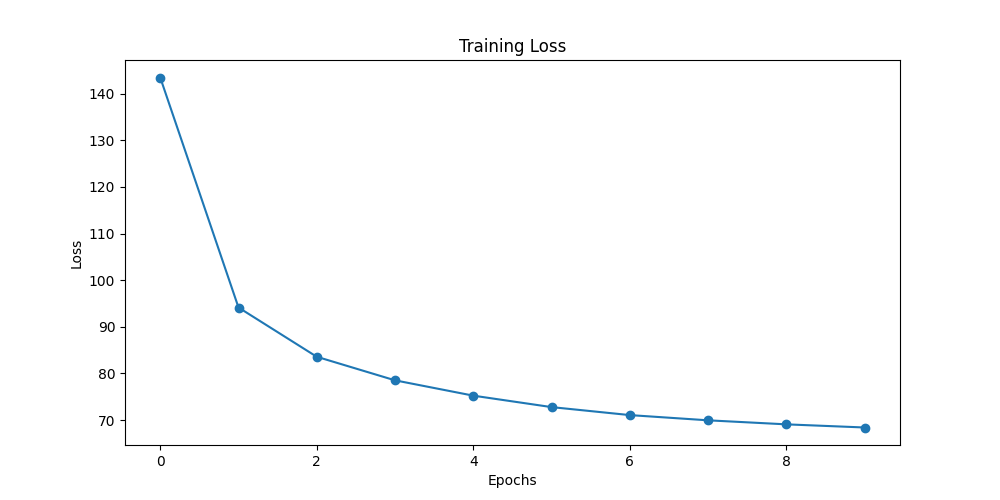

In [13]:
vae_mnist.plot_loss(losses)

# Test the model (qualitatively)

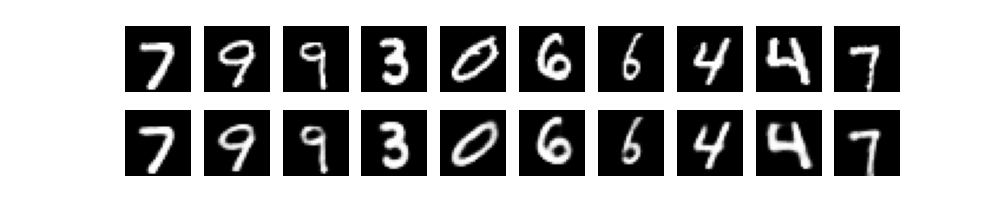

In [14]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True)

vae_mnist.visualize_reconstructions(trained_model, test_loader)

# Generate new digits

In [17]:
plot_samples = 5
num_samples = 100  # Number of digits you want to generate
latent_dim = 20  # Dimension of the latent space
z, generated_digits = vae_mnist.generate_new_digits(trained_model, num_samples)

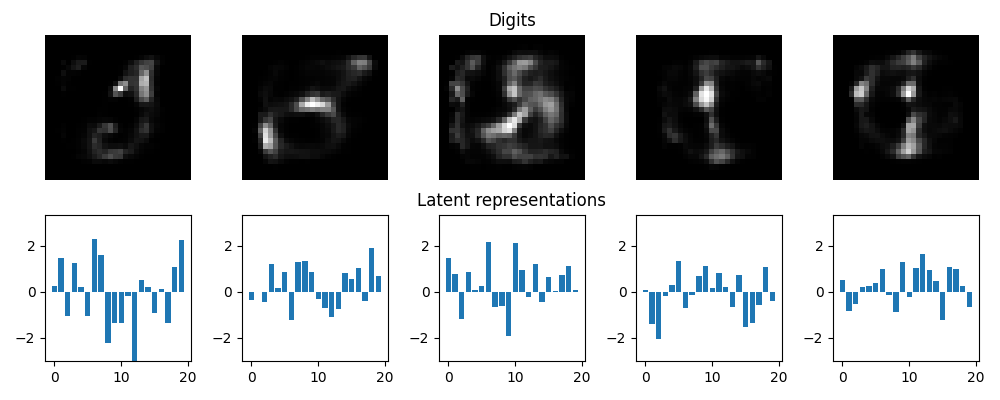

In [18]:
vae_mnist.plot_digits_and_latents(z, generated_digits, plot_samples)

# Project the latent space into 2d space (using t-NSE alg)

In [10]:
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(mnist, batch_size=1000, shuffle=True)

# Get a batch of data
data, labels = next(iter(loader))
data = data.to(device)
labels = labels.numpy()  

# Use the encoder to get the latent variables
trained_model.eval()
with torch.no_grad():
    mu, _ = trained_model.encode(data)
    mu = mu.cpu().numpy()  # Convert to NumPy array for visualization

In [11]:
new_labels = np.concatenate([labels, [11 for i in range(plot_samples)]])#

In [12]:
tsne = TSNE(n_components=2, random_state=0)
full_latent_vectors = np.vstack([mu, z[0:5]])
latent_tsne = tsne.fit_transform(full_latent_vectors)  # Use latent space representations for visualization

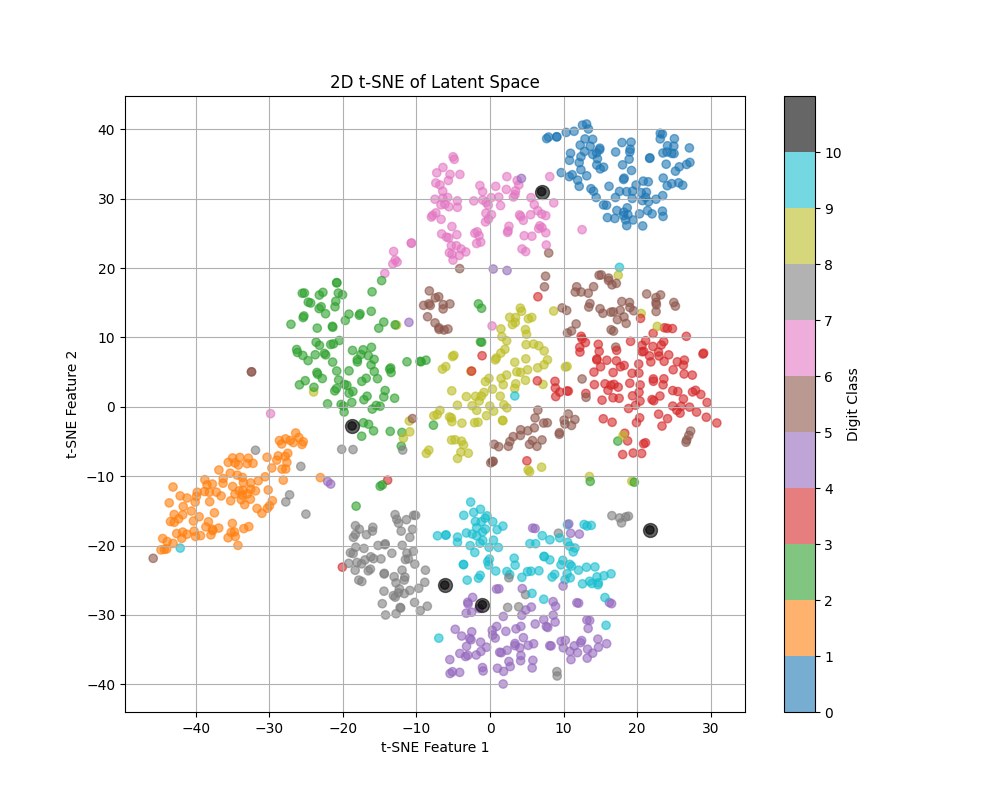

In [13]:
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(10, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000']
custom_cmap = ListedColormap(colors)

scatter = ax.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=new_labels, cmap=custom_cmap, alpha=0.6)
ax.scatter(latent_tsne[-plot_samples:, 0], latent_tsne[-plot_samples:, 1], c='k', s=100, alpha=0.6)

fig.colorbar(scatter, ticks=range(11), label='Digit Class')
ax.set_title('2D t-SNE of Latent Space')
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.grid(True)
plt.show()